In [1]:
! git clone https://github.com/ChenyangLEI/polarization-reflection-removal

fatal: destination path 'polarization-reflection-removal' already exists and is not an empty directory.


In [12]:
# Configured for CUDA > 11.7
! pip install tensorflow==2.12 scipy==1.13.1 numpy==1.23.5 matplotlib==3.9.4


  Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl.metadata (2.5 kB)
  Using cached tensorflow_intel-2.12.0-cp39-cp39-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.12.0-cp39-cp39-win_amd64.whl (1.9 kB)
Using cached tensorflow_intel-2.12.0-cp39-cp39-win_amd64.whl (272.8 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\User\\anaconda3\\envs\\TASHR\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



In [12]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


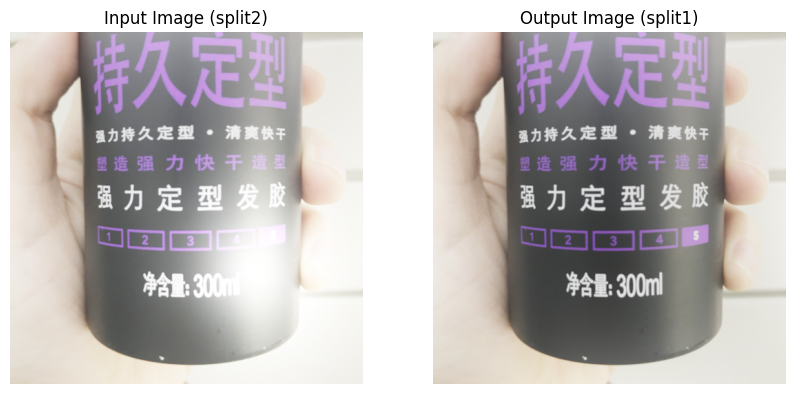

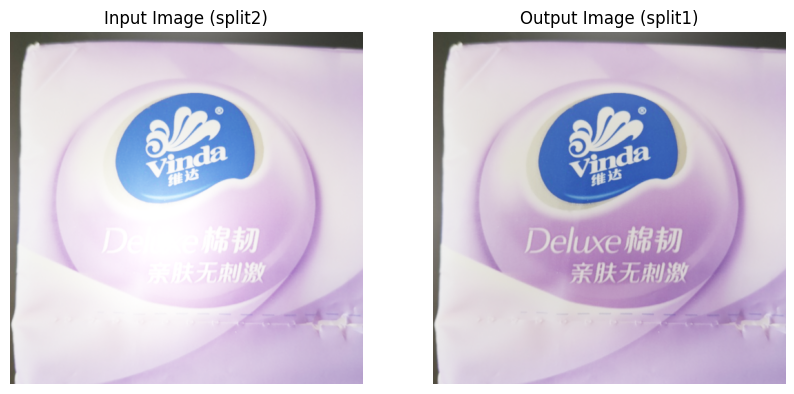

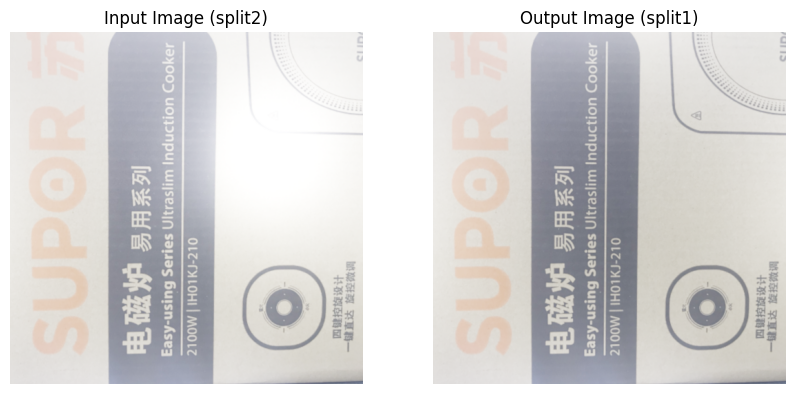

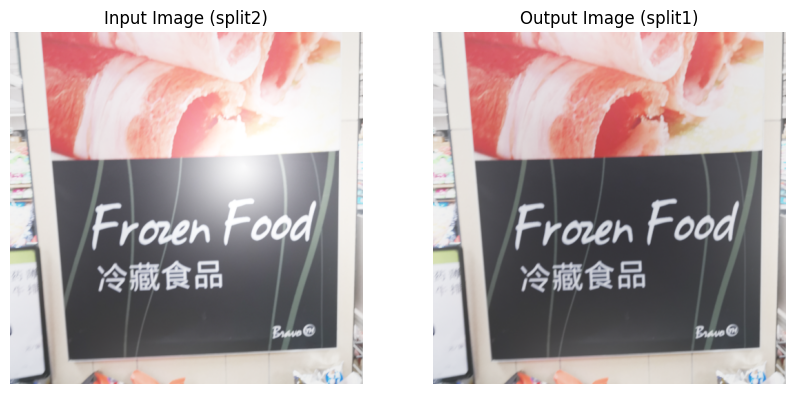

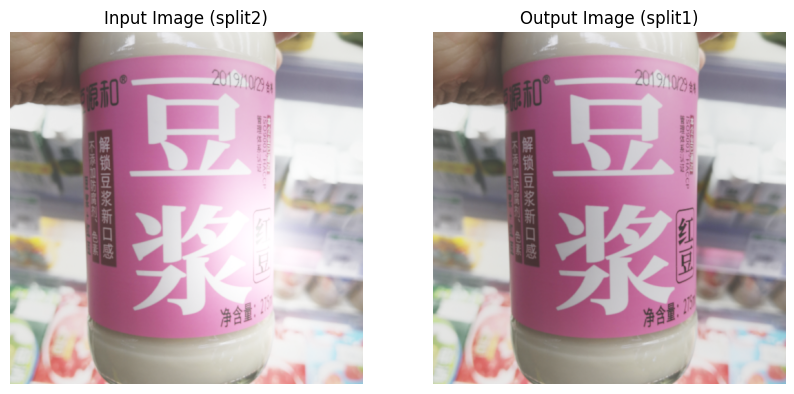

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
def parse_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)  # Read as 3-channel image (RGB)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize image to [0, 1]
    #img = tf.image.rgb_to_grayscale(img)
    #img = tf.repeat(img, 3, axis=-1)  # Repeat grayscale to 3 channels
    split1 = img[:, :512, :]   # First 512 columns (input)
    split2 = img[:, 512:1024, :]  # Next 512 columns (output)
    
    return split2, split1  # Return split2 as input and split1 as output

def load_data(data_dir):
    file_paths = tf.data.Dataset.list_files(data_dir + '/*.png')

    def map_to_pair(file_path):
        split1, split2 = parse_image(file_path)
        return split1, split2  # This becomes (input, output)

    dataset = file_paths.map(map_to_pair, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)  # Add batching and prefetching
    return dataset

train_dataset = load_data('SD1_Trimmed/train')
val_dataset = load_data('SD1_Trimmed/val')
for image_batch, label_batch in train_dataset.take(5):  # Take one batch
    # Convert the batch to numpy for visualization
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    
    # Plot the first image of the batch
    plt.figure(figsize=(10, 5))
    
    # Show the input (split2) and output (split1)
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch[0].squeeze(), cmap='gray')  # squeeze removes the singleton dimension
    plt.title("Input Image (split2)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(label_batch[0].squeeze(), cmap='gray')
    plt.title("Output Image (split1)")
    plt.axis('off')
    
    plt.show()

In [3]:
from tensorflow.keras.applications import VGG19
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping



vgg_path = 'VGG_Model/imagenet-vgg-verydeep-19.mat'
vgg_data = scipy.io.loadmat(vgg_path)

vgg_layers  = vgg_data['layers'][0]
def get_weights(layer_index):
    weights = vgg_layers[layer_index][0][0][2][0][0]
    biases = vgg_layers[layer_index][0][0][2][0][1]
    return weights, biases.reshape(-1)

def build_vgg19_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(512, 512, 3)))  # Input shape for 512x512 RGB images
    
    # Conv1_1
    weights, biases = get_weights(0)
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.layers[-1].set_weights([weights, biases])
    
    # Conv1_2
    weights, biases = get_weights(2)
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.layers[-1].set_weights([weights, biases])
    
    # Add more layers if necessary (using VGG architecture or custom layers)
    
    # Output layer for glare removal (3 channels for RGB)
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output RGB image
    
    return model
model = build_vgg19_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback (stop training when validation loss doesn't improve after 3 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history=model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping])

# Save the model
model.save('path_to_save_model')

Epoch 1/10
 59/375 [===>..........................] - ETA: 21:32 - loss: 0.1146 - mae: 0.2510

: 

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE (L1 Loss)')
plt.plot(history.history['val_mae'], label='Val MAE (L1 Loss)', linestyle='--')
plt.title('Training and Validation L1 Loss (MAE) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('L1 Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
import matplotlib.pyplot as plt

# Take a batch from the validation dataset
for input_batch, output_batch in val_dataset.take(1):
    predictions = model.predict(input_batch)
    break

# Visualize the first input-output-prediction triplet
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Input (split1)")
plt.imshow(input_batch[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth (split2)")
plt.imshow(output_batch[0])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(predictions[0])
plt.axis('off')

plt.tight_layout()
plt.show()

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 512, 3), dtype=float32). Expected shape (None, 512, 512, 3), but input has incompatible shape (32, 512, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 512, 3), dtype=float32)
  • training=False
  • mask=None